In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import ydata_profiling

Load the data

In [33]:
df = pd.read_csv('diabetes.csv')
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [35]:
# check missing values
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [36]:
# check duplicates

df.duplicated().sum()

0

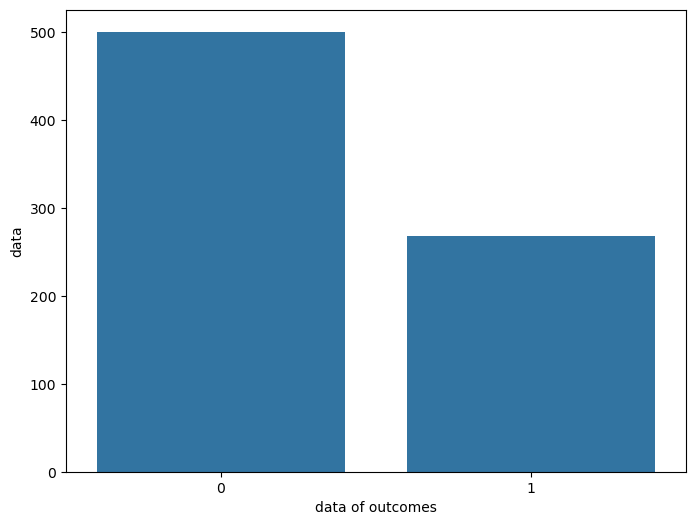

In [37]:
plt.figure(figsize=(8,6))

sns.countplot(x = df['Outcome'], data = df)

plt.xlabel("data of outcomes")
plt.ylabel('data')
plt.show()

In [9]:
profile = ydata_profiling.ProfileReport(df)


In [10]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

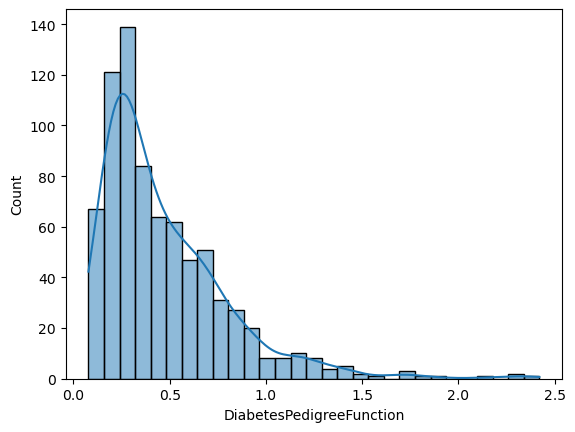

In [11]:
sns.histplot(df['DiabetesPedigreeFunction'], kde = True)
plt.show()

In [12]:
df_log1p = np.log1p(df['DiabetesPedigreeFunction'])

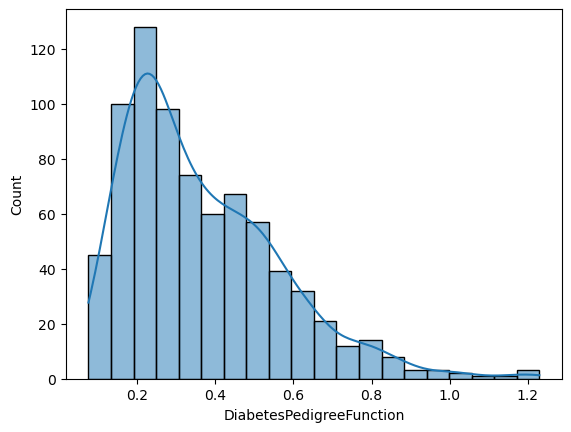

In [13]:
sns.histplot(df_log1p, kde = True)
plt.show()

In [14]:
df_sqrt = np.sqrt(df['DiabetesPedigreeFunction'])

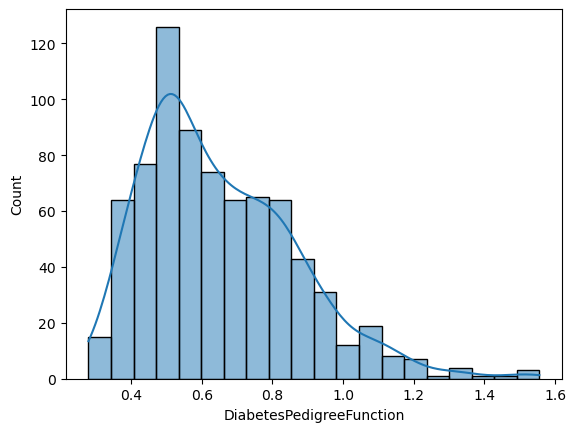

In [15]:
sns.histplot(df_sqrt, kde = True)
plt.show()

In [38]:
df['DiabetesPedigreeFunction'] = np.sqrt(df['DiabetesPedigreeFunction'])

In [39]:
num_cols = [col for col in df.select_dtypes(include = 'number').columns if col not in ['Outcome']]

In [40]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

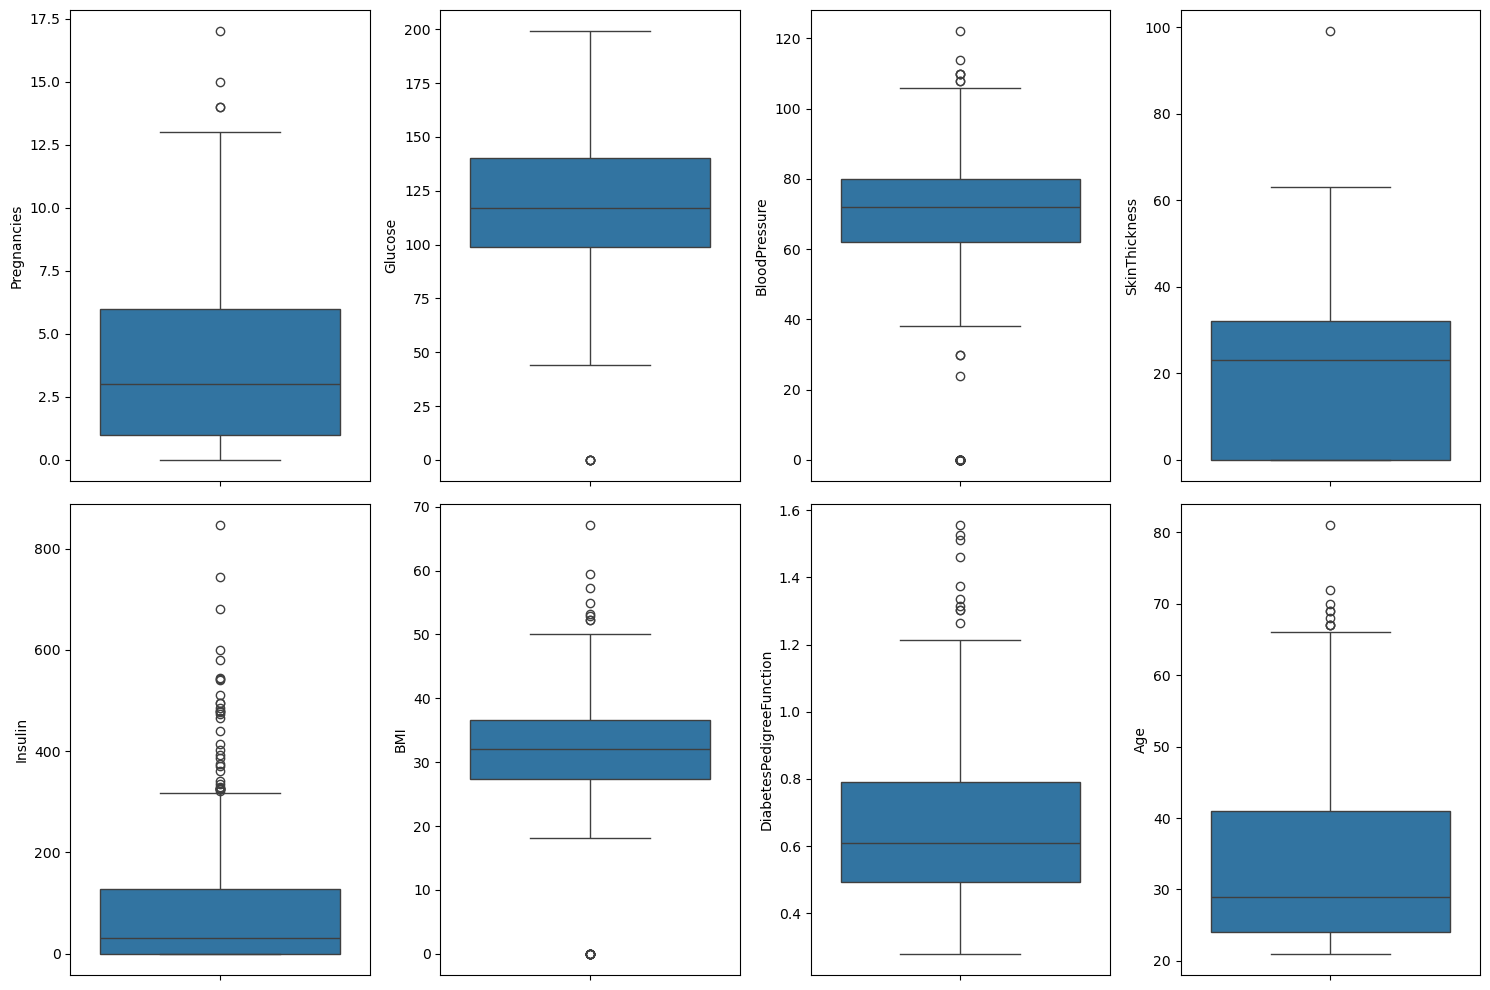

In [20]:
fig, axes = plt.subplots(2, 4, figsize  = (15,10))

for i, col in enumerate(num_cols):
    row, col_position = divmod(i, 4)
    sns.boxplot(data = df, y = col, ax = axes[row, col_position])
    plt.tight_layout()

plt.show()

In [41]:
#remove outliers

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [42]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [43]:
for column in num_cols:
    df = remove_outliers(df, column)

Data preparation

In [44]:
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
5              5      116             74              0        0  25.6   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                    0.791833   50        1  
1                    0.592453   31        0  
2                    0.819756   32        1  
3                    0.408656   21        0  
5                    0.448330   30        0  
..                        ...  ...      ...  
763                  0.413521   63        0  
764                  0.583095   27        0  
765                  0.494975   30        0  
766                  0.590762   47        1  
767                  0.561249   23        0  

[663 rows x 9 columns]

In [45]:
x = df.drop(columns = 'Outcome')
y = df['Outcome']

In [46]:
x.shape

(663, 8)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=2024)

In [48]:
scaler = StandardScaler()

X_train = scaler.fit_transform(x_train)

X_test = scaler.transform(x_test)

In [49]:
#Modeling

model_xgb = xgb.XGBClassifier(seed = 2024)

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [50]:
#EVALUATE MODEL

y_pred = model_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.7168674698795181


In [51]:
#Optimizing using Optuna

def objective(trial):

    params = {
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [52]:
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=50)

[I 2024-12-14 11:29:23,603] A new study created in memory with name: no-name-63d502ec-b96b-40c1-8c47-48cc1a3dbec3
[I 2024-12-14 11:29:24,114] Trial 0 finished with value: 0.7228915662650602 and parameters: {'learning_rate': 0.09768484770241026, 'max_depth': 9, 'subsample': 0.611125768171492, 'colsample_bytree': 0.7526424324140599, 'min_child_weight': 1}. Best is trial 0 with value: 0.7228915662650602.
[I 2024-12-14 11:29:24,348] Trial 1 finished with value: 0.7409638554216867 and parameters: {'learning_rate': 0.0029494721756139213, 'max_depth': 5, 'subsample': 0.4596556032711205, 'colsample_bytree': 0.7762232501711452, 'min_child_weight': 20}. Best is trial 1 with value: 0.7409638554216867.
[I 2024-12-14 11:29:24,589] Trial 2 finished with value: 0.7289156626506024 and parameters: {'learning_rate': 0.098062050058993, 'max_depth': 5, 'subsample': 0.20650681939281657, 'colsample_bytree': 0.09898625557227533, 'min_child_weight': 4}. Best is trial 1 with value: 0.7409638554216867.
[I 2024-

In [53]:
study.best_trial.value

0.7710843373493976

In [54]:
study.best_trial.params

{'learning_rate': 0.012805766193764114,
 'max_depth': 1,
 'subsample': 0.46402324889995905,
 'colsample_bytree': 0.5593026898149056,
 'min_child_weight': 6}

In [55]:
# save the model

best_params = study.best_trial.params

best_model = xgb.XGBClassifier(**best_params)

best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5593026898149056, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012805766193764114,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [56]:
import joblib

joblib.dump(best_model, 'best_xgb_model.joblib')

['best_xgb_model.joblib']

In [58]:
x_train.to_csv('X_train.csv', index = False)